# Starbucks Capstone Project

## 1. Business Understanding

•	The program used to create the data simulates how people make purchasing decisions and how those decisions are influenced by promotional offers.

•	The basic task is to use the data to identify which groups of people are most responsive to each type of offer, and how best to present each type of offer. In detail, your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. 

## 2. Data Understanding

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline


In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)

In [3]:
profile = pd.read_json('data/profile.json', orient='records', lines=True)

In [4]:
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

Firstly, check portfolio data.

In [5]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [6]:
portfolio.shape

(10, 6)

In [7]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [8]:
portfolio['id'].duplicated().sum()

0

We can see that this dataframe is small and contains no missing values.

Next, check profile data.

In [9]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [10]:
profile.shape

(17000, 5)

In [11]:
profile['id'].duplicated().sum()

0

In [12]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [13]:
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [14]:
(profile['gender'].isna() & profile['income'].isna()).sum()

2175

There are missing values in the gender column and income column. We can see that they all happen simultaneously. In another words, there are 14825 rows contain full information. And there are 2175 rows contain values with both gender and income missing.

In [15]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [16]:
transcript.shape

(306534, 4)

In [17]:
transcript['person'].duplicated().sum()

289534

In [18]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


We can see there is no missing values in transcript dataframe.

## 3. Data Preparation

Data cleaning especially important and tricky.

### 3.1 portfolio dataframe

For this dataframe, we don't have to worry about missing values. However, the channel column contains informations that are difficult to process. We want to do:

A. break this column up in to dummy variables. 

B. get dummy variables for the categorical column 'offer_type'. 

C. rename column 'id' to 'offer_id' to avoid future confusion and reconstruct the dataframe and use offer_id as index.

In [19]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


Part A

In [20]:
channel_type = set()
for item in portfolio['channels']:
    channel_type.update(set(item))

channel_type = list(channel_type)

In [21]:
for type in channel_type:
    portfolio[type] = portfolio['channels'].apply(lambda chan: type in chan).apply(int)

portfolio.drop(labels='channels', axis=1, inplace=True)    
portfolio.head(10)

,reward,difficulty,duration,offer_type,id,mobile,email,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


Part B

In [22]:
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [23]:
dummies = pd.DataFrame(pd.get_dummies(portfolio['offer_type']))

In [24]:
portfolio = pd.concat([portfolio, dummies], axis=1)

In [25]:
# portfolio.drop(labels='offer_type', axis=1, inplace=True)
portfolio.head(10)

,reward,difficulty,duration,offer_type,id,mobile,email,social,web,bogo,discount,informational
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,0,1,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


Part C

In [26]:
portfolio.rename(columns = {'id':'offer_id'}, inplace=True)

In [27]:
portfolio.set_index('offer_id')

,reward,difficulty,duration,offer_type,mobile,email,social,web,bogo,discount,informational
offer_id,,,,,,,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,bogo,1,1,1,0,1,0,0
4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,bogo,1,1,1,1,1,0,0
3f207df678b143eea3cee63160fa8bed,0,0,4,informational,1,1,0,1,0,0,1
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1,1,0,1,1,0,0
0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,discount,0,1,0,1,0,1,0
2298d6c36e964ae4a3e7e9706d1fb8c2,3,7,7,discount,1,1,1,1,0,1,0
fafdcd668e3743c1bb461111dcafc2a4,2,10,10,discount,1,1,1,1,0,1,0
5a8bc65990b245e5a138643cd4eb9837,0,0,3,informational,1,1,1,0,0,0,1
f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,bogo,1,1,1,1,1,0,0


In [28]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   reward         10 non-null     int64 
 1   difficulty     10 non-null     int64 
 2   duration       10 non-null     int64 
 3   offer_type     10 non-null     object
 4   offer_id       10 non-null     object
 5   mobile         10 non-null     int64 
 6   email          10 non-null     int64 
 7   social         10 non-null     int64 
 8   web            10 non-null     int64 
 9   bogo           10 non-null     uint8 
 10  discount       10 non-null     uint8 
 11  informational  10 non-null     uint8 
dtypes: int64(7), object(2), uint8(3)
memory usage: 878.0+ bytes


### 3.2 profile dataframe

A. As shown in Section 2, there are missing values in the gender and income columns. We will drop these rows.

B. We also can see from the head of the dataframe that there are entries with age of 118. This is very unlikely. Since all 3 cases happend in the rows being dropped, we will check the range of ages after the dropping.

C. The became_member_on column contains the dates as int. We will transform those data into appropriate format.

D. We get dummies for the gender column. There are three types: F, M, and O.

E. We will change column name 'id' into 'customer_id' and set it as index.

In [29]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


Part A

In [30]:
profile.dropna(how='any', inplace=True)

In [31]:
profile.isna().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

Part B

In [32]:
profile['age'].max(), profile['age'].min()

(101, 18)

After dropping rows, the range of ages seems reasonable. No change applied.

Part C

In [33]:
profile['became_member_on']= profile['became_member_on'].apply(lambda x: datetime.strptime(str(x),'%Y%m%d'))

Part D

In [34]:
profile['gender'].unique()

array(['F', 'M', 'O'], dtype=object)

In [35]:
dummies = pd.DataFrame(pd.get_dummies(profile['gender']))

In [36]:
profile = pd.concat([profile, dummies], axis=1)

In [37]:
# profile.drop(labels='gender', axis=1, inplace=True)

Part E

In [38]:
profile.rename(columns = {'id':'customer_id'}, inplace=True)

In [39]:
profile.set_index('customer_id')

,gender,age,became_member_on,income,F,M,O
customer_id,,,,,,,
0610b486422d4921ae7d2bf64640c50b,F,55,2017-07-15,112000.0,1,0,0
78afa995795e4d85b5d9ceeca43f5fef,F,75,2017-05-09,100000.0,1,0,0
e2127556f4f64592b11af22de27a7932,M,68,2018-04-26,70000.0,0,1,0
389bc3fa690240e798340f5a15918d5c,M,65,2018-02-09,53000.0,0,1,0
2eeac8d8feae4a8cad5a6af0499a211d,M,58,2017-11-11,51000.0,0,1,0
...,...,...,...,...,...,...,...
6d5f3a774f3d4714ab0c092238f3a1d7,F,45,2018-06-04,54000.0,1,0,0
2cb4f97358b841b9a9773a7aa05a9d77,M,61,2018-07-13,72000.0,0,1,0
01d26f638c274aa0b965d24cefe3183f,M,49,2017-01-26,73000.0,0,1,0


In [40]:
profile['valid'] = 1

### 3.3 transcript dataframe

In [43]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [44]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [45]:
transcript[transcript['event'] == 'transaction'].iloc[0:2]

,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0


In [46]:
transcript[transcript['event'] == 'offer received'].iloc[0:2]

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [47]:
transcript[transcript['event'] == 'offer viewed'].iloc[0:2]

,person,event,value,time
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0


In [48]:
transcript[transcript['event'] == 'offer completed'].iloc[0:2]

,person,event,value,time
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0


After exploring, I found that the data can be split into two categories. The first one is about purchasing. The second one is about offers. So I will split the data into two dataframes containing each type.

A. Change column name from person to customer_id.

B. Split transcript in to transactions and event offer on different events.

C. For each dataframe, extract data from the value column. It will be a float number for transactions, named 'amount', and a string of offer id, named 'offer_id', for offer. 

After the spliting and data extraction, the event column and the value column will be dropped for transactions. The value column will be dropped for offers.

D. Get dummies for offer events

E. In case that offers and transactions are modeled together in the future, I will also dummy transcripts.

I also found duplicates in the person column. So the index will remain the same.

Part A

In [49]:
transcript.rename(columns = {'person':'customer_id'}, inplace=True)

Part B

In [50]:
transactions = transcript[transcript['event'] == 'transaction'].copy()

In [51]:
offers = transcript[transcript['event'] != 'transaction'].copy()

In [52]:
transactions.shape[0] + offers.shape[0] == transcript.shape[0]

True

In [53]:
transactions.shape[1] == transcript.shape[1]

True

In [54]:
offers.shape[1] == transcript.shape[1]

True

Part C

Firstly, the transactions dataframe

In [55]:
transactions.head()

,customer_id,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0


In [56]:
amount = transactions['value'].apply(lambda x: float(x.get('amount')))

In [57]:
transactions.drop(labels=['event','value'], axis=1, inplace=True)

In [58]:
transactions = pd.concat([transactions, amount],axis=1)

In [59]:
transactions.rename(columns = {'value':'amount'}, inplace=True)

In [60]:
transactions.head()

,customer_id,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


Then the offer dataframe

In [61]:
offers.head()

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [62]:
offer_id = offers['value'].apply(lambda x: x.get('offer id'))

In [63]:
offers.drop(labels='value', axis=1, inplace=True)

In [64]:
offers = pd.concat([offers, offer_id], axis=1)

In [65]:
offers.rename(columns = {'value':'offer_id'}, inplace=True)

In [66]:
offers.head()

,customer_id,event,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0


Part D

In [67]:
dummies = pd.DataFrame(pd.get_dummies(transcript['event']))

In [68]:
transcript = pd.concat([transcript, dummies], axis=1)

In [69]:
transcript['offer_id'] = [[*v.values()][0]
                                    if [*v.keys()][0] in ['offer id',
                                                          'offer_id'] else None
                                    for v in transcript.value]

In [70]:
transcript['amount'] = [np.round([*v.values()][0], decimals=2)
                                  if [*v.keys()][0] == 'amount' else None
                                  for v in transcript.value]

In [71]:
transcript.drop('value', axis=1, inplace=True)

In [72]:
transcript.head()

,customer_id,event,time,offer completed,offer received,offer viewed,transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


Part D

In [73]:
dummies = pd.DataFrame(pd.get_dummies(offers['event']))

In [74]:
offers = pd.concat([offers, dummies], axis=1)

In [75]:
# offer.drop(labels='event', axis=1, inplace=True)

In [76]:
offers.head()

,customer_id,event,time,offer_id,offer completed,offer received,offer viewed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0


### 3.4 Data Visualization

In [77]:
profile.head()

,gender,age,customer_id,became_member_on,income,F,M,O,valid
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0,0,1
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,0,0,1
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,0,1,0,1
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,0,1,0,1
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,0,1,0,1


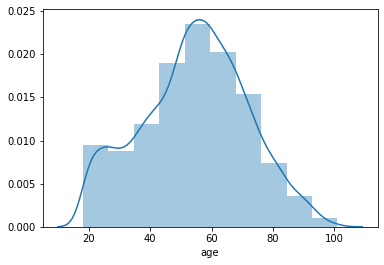

In [78]:
sns.distplot(profile['age'], bins=10);

The highest number of customers are in their 50's. The distribution of the age is nearly normal.

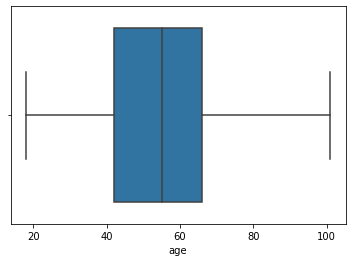

In [79]:
sns.boxplot(x=profile['age']);

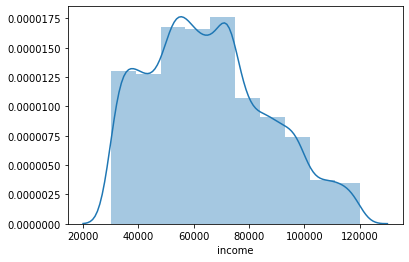

In [80]:
sns.distplot(profile['income'], bins=10);

The distribution of income is skewed to the lower end.

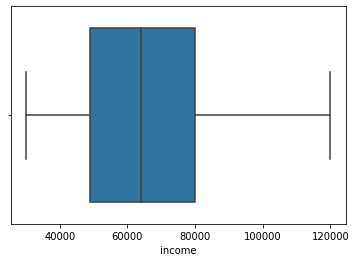

In [81]:
sns.boxplot(x=profile['income']);

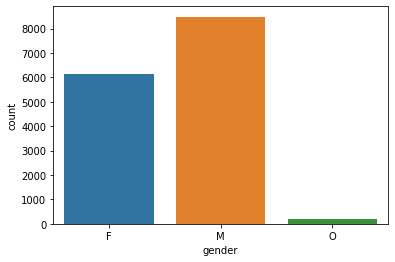

In [82]:
sns.countplot(x='gender', data=profile);

There are more male customers than the female.

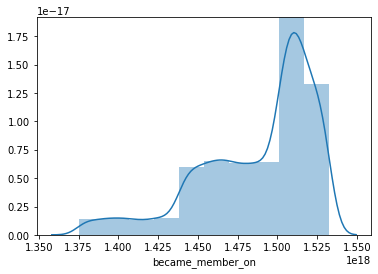

In [83]:
sns.distplot(profile['became_member_on'], bins=10)

In [84]:
transactions.head()

,customer_id,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


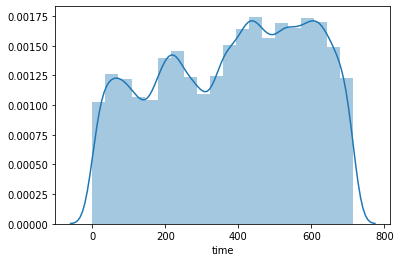

In [85]:
sns.distplot(transactions['time'], bins=20);

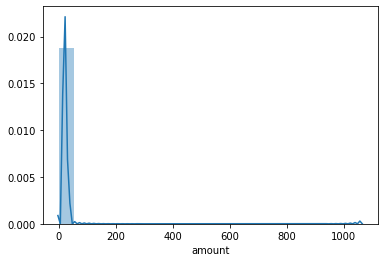

In [86]:
sns.distplot(transactions['amount'], bins=20);

In [87]:
offers.head()

,customer_id,event,time,offer_id,offer completed,offer received,offer viewed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0


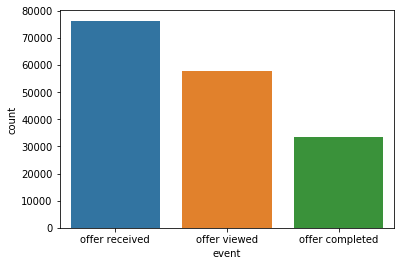

In [88]:
sns.countplot('event',data=offers);

This graph shows the data is reasonable since offers reviewed should be less than received and more than completed.

## 4. Modeling

Firstly, create a dataframe df to combine all factors together. Also change column names that contain spaces.

In [89]:
transcript.head()

,customer_id,event,time,offer completed,offer received,offer viewed,transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [90]:
transcript.rename(columns = {'offer completed':'event_offer_completed'}, inplace=True)

In [91]:
transcript.rename(columns = {'offer received':'event_offer_received'}, inplace=True)

In [92]:
transcript.rename(columns = {'offer viewed':'event_offer_viewed'}, inplace=True)

In [93]:
transcript.rename(columns = {'transaction':'event_transaction'}, inplace=True)

In [94]:
# df2 = pd.merge(profile, offers, left_on='customer_id', right_on='customer_id', how='inner')
df2 = pd.merge(profile, transcript, left_on='customer_id', right_on='customer_id', how='inner')

In [95]:
df2.head()

,gender,age,customer_id,became_member_on,income,F,M,O,valid,event,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0,0,1,transaction,18,0,0,0,1,None,21.51
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0,0,1,transaction,144,0,0,0,1,None,32.28
2,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0,0,1,offer received,408,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
3,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0,0,1,offer received,504,0,1,0,0,3f207df678b143eea3cee63160fa8bed,NaN
4,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0,0,1,transaction,528,0,0,0,1,None,23.22


In [96]:
# df3 = pd.merge(df2, transactions, left_on='customer_id', right_on='customer_id', how='inner')

In [97]:
df = pd.merge(df2, portfolio, on='offer_id', how='left')

In [98]:
offer_map = {'ae264e3637204a6fb9bb56bc8210ddfd': 'B1',
                '4d5c57ea9a6940dd891ad53e9dbe8da0': 'B2',
                '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'B3',
                'f19421c1d4aa40978ebb69ca19b0e20d': 'B4',
                '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'D1',
                '2298d6c36e964ae4a3e7e9706d1fb8c2': 'D2',
                'fafdcd668e3743c1bb461111dcafc2a4': 'D3',
                '2906b810c7d4411798c6938adc9daaa5': 'D4',
                '3f207df678b143eea3cee63160fa8bed': 'I1',
                '5a8bc65990b245e5a138643cd4eb9837': 'I2'}

In [99]:
df.offer_id = df.offer_id.apply(lambda x: offer_map[x] if x else None)

In [100]:
df.columns

Index(['gender', 'age', 'customer_id', 'became_member_on', 'income', 'F', 'M',
       'O', 'valid', 'event', 'time', 'event_offer_completed',
       'event_offer_received', 'event_offer_viewed', 'event_transaction',
       'offer_id', 'amount', 'reward', 'difficulty', 'duration', 'offer_type',
       'mobile', 'email', 'social', 'web', 'bogo', 'discount',
       'informational'],
      dtype='object')

Introduce functions and models

In [101]:
def get_offer_cust(df, offer_type=None):
    """
    Get offer data (received, viewed and completed) per customer and
    offer type
    Inputs:
    - df: dataframe of merged transactions, portfolio and profile data
    - offer_type: informational, bogo or discount
    Output:
    - aggregated data per customer and offer type
    """
    data = dict()
    for e in ['received', 'viewed', 'completed']:
        # Informational offers don't have completed data
        if offer_type == 'informational' and e == 'completed':
            continue
        flag = (df['event_offer_{}'.format(e)] == 1)
        key = e
        if offer_type:
            flag = flag & (df.offer_type == offer_type)
            key = '{}_'.format(offer_type) + key
        data[key] = df[flag].groupby('customer_id').offer_id.count()
    # Informational offers don't have reward data
    flag = (df.event_offer_completed == 1)
    if offer_type != 'informational':
        key = 'reward'
        if offer_type:
            flag = flag & (df.offer_type == offer_type)
            key = '{}_'.format(offer_type) + key
        data[key] = df[flag].groupby('customer_id').reward.sum()

    return data


def get_offer_id_cust(df, offer_id):
    """
    Get offer data (received, viewed and completed) per customer
    and offer id
    Inputs:
    - df: dataframe of merged transactions, portfolio and profile data
    - offer_id: B1, B2, ...
    Output:
    - aggregated data per customer and offer id
    """
    data = dict()

    for e in ['received', 'viewed', 'completed']:
        # Informational offers don't have completed data
        if offer_id in ['I1', 'I2'] and e == 'completed':
            continue
        event = 'event_offer_{}'.format(e)
        flag = (df[event] == 1) & (df.offer_id == offer_id)
        key = '{}_{}'.format(offer_id, e)
        data[key] = df[flag].groupby('customer_id').offer_id.count()

    # Informational offers don't have reward data
    flag = (df.event_offer_completed == 1) & (df.offer_id == offer_id)
    if offer_id not in ['I1', 'I2']:
        key = '{}_reward'.format(offer_id)
        data[key] = df[flag].groupby('customer_id').reward.sum()

    return data


def round_age(x):
    """
    Round age to the 5th of each 10th (15, 25,..., 105)
    Input:
    - x: age
    Output:
    - rounded age. Returns 0 if the value is less than 15 or more than 105
    """
    for y in range(15, 106, 10):
        if x >= y and x < y+10:
            return y
    return 0


def round_income(x):
    """
    Round income to the lower 10000th
    Intput:
    - income
    Output:
    - lower 10000th of the income. Return 0 if the income
    is less than 30,000 or more than 120,000
    """
    for y in range(30, 130, 10):
        if x >= y*1000 and x < (y+10)*1000:
            return y*1000
    return 0


def per_customer_data(df, profile):
    """ Build a dataframe with aggregated purchase and offer data and demographics
    Input:
    - df: merged dataframe with transactions, customer and offer data
    Output:
    - customer: dataframe with aggregated data
    """
    cust_dict = dict()
    # Get total transaction data
    transactions = df[df.event_transaction == 1].groupby('customer_id')
    cust_dict['total_expense'] = transactions.amount.sum()
    cust_dict['total_transactions'] = transactions.amount.count()
    # Get  aggr offer data
    cust_dict.update(get_offer_cust(df))
    # Get offer type data
    for ot in ['bogo', 'discount', 'informational']:
        cust_dict.update(get_offer_cust(df, ot))
    # Get offer id data
    for oi in ['B1', 'B2', 'B3', 'B4', 'D1', 'D2', 'D3', 'D4', 'I1', 'I2']:
        cust_dict.update(get_offer_id_cust(df, oi))

    customers = pd.concat(cust_dict.values(), axis=1, sort=False);
    customers.columns = cust_dict.keys()
    customers.fillna(0, inplace=True)

    # Add demographic data
    customers = pd.merge(customers, profile.set_index('customer_id'),
                         left_index=True, right_index=True)
    customers['age_group'] = customers.age.apply(round_age)
    customers['income_group'] = customers.income.apply(round_income)
    customers['net_expense'] = customers['total_expense'] - customers['reward']

    return customers


def get_offer_stat(customers, stat, offer):
    """ Get any column for customers that received but not viewed an offer,
    viewed but not completed the offer, and those that viewed and completed
    the offer
    Input:
    - customers: dataframe with aggregated data of the offers
    - stat: column of interest
    - offer: offer of interest
    Output:
    - (received, viewed, completed): tuple with the corresponding column
    """
    valid = (customers.valid == 1)
    rcv_col = '{}_received'.format(offer)
    vwd_col = '{}_viewed'.format(offer)
    received = valid & (customers[rcv_col] > 0) & (customers[vwd_col] == 0)
    cpd = None
    if offer not in ['informational', 'I1', 'I2']:
        cpd_col = '{}_completed'.format(offer)
        viewed = valid & (customers[vwd_col] > 0) & (customers[cpd_col] == 0)
        completed = valid & (customers[vwd_col] > 0) & (customers[cpd_col] > 0)
        cpd = customers[completed][stat]
    else:
        viewed = valid & (customers[vwd_col] > 0)

    return customers[received][stat], customers[viewed][stat], cpd


def get_average_expense(customers, offer):
    """ Get the average expense for customers that received but not
    viewed an offer, viewed but not completed the offer, and those
    that viewed and completed the offer
    Input:
    - customers: dataframe with aggregated data of the offers
    - offer: offer of interest
    Output:
    - (received, viewed, completed): tuple with the average expense
    """
    rcv_total, vwd_total, cpd_total = get_offer_stat(customers,
                                                     'total_expense', offer)
    rcv_trans, vwd_trans, cpd_trans = get_offer_stat(customers,
                                                     'total_transactions',
                                                     offer)

    rcv_avg = rcv_total / rcv_trans
    rcv_avg.fillna(0, inplace=True)
    vwd_avg = vwd_total / vwd_trans
    vwd_avg.fillna(0, inplace=True)

    cpd_avg = None
    if offer not in ['informational', 'I1', 'I2']:
        cpd_avg = cpd_total / cpd_trans

    return rcv_avg, vwd_avg, cpd_avg


def get_average_reward(customers, offer):
    """ Get the average reward received by customers that completed the offer
    Input:
    - customers: dataframe with aggregated data of the offers
    - offer: offer of interest
    Output:
    - reward: average reward
    """
    cpd_col = '{}_completed'.format(offer)
    rwd_col = '{}_reward'.format(offer)
    completed = customers[(customers.valid == 1) & (customers[cpd_col] > 0)]

    return completed[rwd_col] / completed[cpd_col]


def get_offer_stat_by(customers, stat, offer, by_col, aggr='sum'):
    """ Get any column for customers that received but not viewed an offer,
    viewed but not completed the offer, and those that viewed and completed
    the offer, grouped by a column
    Input:
    - customers: dataframe with aggregated data of the offers
    - stat: column of interest
    - offer: offer of interest
    - by_col: column used to group the data
    - aggr: aggregation method sum or mean
    Output:
    - (received, viewed, completed): tuple with sum aggregation
    """
    valid = (customers.valid == 1)
    rcv_col = '{}_received'.format(offer)
    vwd_col = '{}_viewed'.format(offer)
    received = valid & (customers[rcv_col] > 0) & (customers[vwd_col] == 0)
    cpd = None
    if offer not in ['informational', 'I1', 'I2']:
        cpd_col = '{}_completed'.format(offer)
        viewed = valid & (customers[vwd_col] > 0) & (customers[cpd_col] == 0)
        completed = valid & (customers[cpd_col] > 0)
        if aggr == 'sum':
            cpd = customers[completed].groupby(by_col)[stat].sum()
        elif aggr == 'mean':
            cpd = customers[completed].groupby(by_col)[stat].mean()
    else:
        viewed = valid & (customers[vwd_col] > 0)
    if aggr == 'sum':
        rcv = customers[received].groupby(by_col)[stat].sum()
        vwd = customers[viewed].groupby(by_col)[stat].sum()
    elif aggr == 'mean':
        rcv = customers[received].groupby(by_col)[stat].mean()
        vwd = customers[viewed].groupby(by_col)[stat].mean()

    return rcv, vwd, cpd


def get_average_expense_by(customers, offer, by_col):
    """ Get the average expense for customers that received but not
    viewed an offer, viewed but not completed the offer, and those
    that viewed and completed the offer, group by a column
    Input:
    - customers: dataframe with aggregated data of the offers
    - offer: offer of interest
    - by_col: column used to group the data
    Output:
    - (received, viewed, completed): tuple with the average expense
    """
    rcv_total, vwd_total, cpd_total = get_offer_stat_by(customers,
                                                        'total_expense',
                                                        offer, by_col)
    rcv_trans, vwd_trans, cpd_trans = get_offer_stat_by(customers,
                                                        'total_transactions',
                                                        offer, by_col)

    rcv_avg = rcv_total / rcv_trans
    rcv_avg.fillna(0, inplace=True)
    vwd_avg = vwd_total / vwd_trans
    vwd_avg.fillna(0, inplace=True)

    cpd_avg = None
    if offer not in ['informational', 'I1', 'I2']:
        cpd_avg = cpd_total / cpd_trans

    return rcv_avg, vwd_avg, cpd_avg


def get_average_reward_by(customers, offer, by_col):
    """ Get the average reward received by customers that completed
    the offer, grouped by a column
    Input:
    - customers: dataframe with aggregated data of the offers
    - offer: offer of interest
    - by_col: column used to group the data
    Output:
    - reward: average reward
    """
    cpd_col = '{}_completed'.format(offer)
    rwd_col = '{}_reward'.format(offer)
    completed = customers[(customers.valid == 1) &
                          (customers[cpd_col] > 0)].groupby(by_col)

    return completed[rwd_col].sum() / completed[cpd_col].count()



def plot_offer_expense(customers, offer):
    """ Plot the histograms of the total expense and the average
    expense per transaction incurred by customers that have received,
    viewed and completed an offer.
    Input:
    - customers: dataframe with aggregated data of the offers
    - offer: offer of interest
    """
    rcv, vwd, cpd = get_offer_stat(customers, 'total_expense', offer)
    rcv_avg, vwd_avg, cpd_avg = get_average_expense(customers, offer)

    plt.figure(figsize=(16, 5))
    bins = 100

    plt.subplot(121)
    plt.hist(rcv, bins, alpha=0.5, label='{}-received'.format(offer))
    plt.hist(vwd, bins, alpha=0.5, label='{}-viewed'.format(offer))
    if offer not in ['informational', 'I1', 'I2']:
        plt.hist(cpd, bins, alpha=0.5, label='{}-completed'.format(offer))
    plt.legend(loc='best')
    ax = plt.gca();
    ax.set_xlim(0, 600);
    plt.title('Total Transaction ($)')
    plt.grid();

    plt.subplot(122)
    plt.hist(rcv_avg, bins, alpha=0.5, label='{}-received'.format(offer))
    plt.hist(vwd_avg, bins, alpha=0.5, label='{}-viewed'.format(offer))
    if offer not in ['informational', 'I1', 'I2']:
        plt.hist(cpd_avg, bins, alpha=0.5, label='{}-completed'.format(offer))
    plt.legend(loc='best')
    ax = plt.gca();
    ax.set_xlim(0, 50);
    plt.title('Average Transaction ($)')
    plt.grid();


def plot_offer_reward(customers, offer):
    """ Plot the histograms of the total reward and the average
    reward received by customers that completed an offer.
    Input:
    - customers: dataframe with aggregated data of the offers
    - offer: offer of interest
    """
    plt.figure(figsize=(16, 5))
    bins = 10

    key = '{}_completed'.format(offer)
    key_avg = '{}_reward'.format(offer)
    rwd = customers[(customers.valid == 1) & (customers[key] > 0)][key_avg]
    rwd_avg = get_average_reward(customers, offer)

    plt.subplot(121)
    plt.hist(rwd, bins, alpha=0.5, label=offer)
    plt.title('Total Reward ($)');
    plt.legend(loc='best');
    plt.grid();

    plt.subplot(122)
    plt.hist(rwd_avg, bins, alpha=0.5, label=offer)
    plt.title('Average Reward ($)');
    plt.legend(loc='best');
    plt.grid();


def plot_offer_expense_by(customers, offer):
    """ Plot the total expense and the average expense per transaction
    incurred by customers that have received, viewed and completed an offer.
    The plots are separated by age, income and gender.
    Input:
    - customers: dataframe with aggregated data of the offers
    - offer: offer of interest
    """
    rcv_by = dict()
    vwd_by = dict()
    cpd_by = dict()
    rcv_avg_by = dict()
    vwd_avg_by = dict()
    cpd_avg_by = dict()

    for key in ['age_group', 'income_group', 'gender']:
        rcv_by[key], vwd_by[key], cpd_by[key] = get_offer_stat_by(customers,
                                                                  'net_expense',
                                                                  offer, key,
                                                                  aggr='mean')
        by_data = get_average_expense_by(customers, offer, key)
        rcv_avg_by[key], vwd_avg_by[key], cpd_avg_by[key] = by_data

    plt.figure(figsize=(16, 10))

    plt.subplot(231)
    plt.plot(rcv_by['age_group'], label='{}-received'.format(offer))
    plt.plot(vwd_by['age_group'], label='{}-viewed'.format(offer))
    if offer not in ['informational', 'I1', 'I2']:
        plt.plot(cpd_by['age_group'], label='{}-completed'.format(offer))
    plt.legend(loc='best')
    plt.title('Net Expense');
    plt.grid();

    plt.subplot(232)
    plt.plot(rcv_by['income_group'], label='{}-received'.format(offer))
    plt.plot(vwd_by['income_group'], label='{}-viewed'.format(offer))
    if offer not in ['informational', 'I1', 'I2']:
        plt.plot(cpd_by['income_group'], label='{}-completed'.format(offer))
    plt.legend(loc='best')
    plt.title('Net Expense');
    plt.grid();

    index = np.array([0, 1, 2])
    bar_width = 0.3
    plt.subplot(233)
    plt.bar(index, rcv_by['gender'].reindex(['M', 'F', 'O']),
            bar_width, label='{}-received'.format(offer))
    plt.bar(index + bar_width, vwd_by['gender'].reindex(['M', 'F', 'O']),
            bar_width, label='{}-viewed'.format(offer))
    if offer not in ['informational', 'I1', 'I2']:
        plt.bar(index + 2*bar_width, cpd_by['gender'].reindex(['M', 'F', 'O']),
                bar_width, label='{}-completed'.format(offer))
    plt.grid();
    plt.legend(loc='best');
    plt.title('Net Expense');
    plt.xticks(index + bar_width, ('M', 'F', 'O'));

    plt.subplot(234)
    plt.plot(rcv_avg_by['age_group'], label='{}-received'.format(offer))
    plt.plot(vwd_avg_by['age_group'], label='{}-viewed'.format(offer))
    if offer not in ['informational', 'I1', 'I2']:
        plt.plot(cpd_avg_by['age_group'], label='{}-completed'.format(offer))
    plt.legend(loc='best')
    plt.title('Average Transaction Value');
    plt.grid();

    plt.subplot(235)
    plt.plot(rcv_avg_by['income_group'], label='{}-received'.format(offer))
    plt.plot(vwd_avg_by['income_group'], label='{}-viewed'.format(offer))
    if offer not in ['informational', 'I1', 'I2']:
        plt.plot(cpd_avg_by['income_group'], label='{}-completed'.format(offer))
    plt.legend(loc='best')
    plt.title('Average Transaction Value');
    plt.grid();

    plt.subplot(236)
    plt.bar(index, rcv_avg_by['gender'].reindex(['M', 'F', 'O']), bar_width,
            label='{}-received'.format(offer))
    plt.bar(index + bar_width, vwd_avg_by['gender'].reindex(['M', 'F', 'O']),
            bar_width, label='{}-viewed'.format(offer))
    if offer not in ['informational', 'I1', 'I2']:
        plt.bar(index+2*bar_width, cpd_avg_by['gender'].reindex(['M', 'F', 'O']),
                bar_width, label='{}-completed'.format(offer))
    plt.grid();
    plt.legend(loc='best');
    plt.title('Average Transaction Value');
    plt.xticks(index + bar_width, ('M', 'F', 'O'));


def plot_offer_reward_by(customers, offer):
    """ Plot the total and average reward received by all customers that
    completed an offer in a specific group. The plots are separated by age,
    income and gender.
    Input:
    - customers: dataframe with aggregated data of the offers
    - offer: offer of interest
    """
    rwd_by = dict()
    rwd_avg_by = dict()

    for key in ['age_group', 'income_group', 'gender']:
        key_cpd = '{}_completed'.format(offer)
        key_rwd = '{}_reward'.format(offer)
        offer_cpd = customers[(customers.valid == 1) &
                              (customers[key_cpd] > 0)].groupby(key)
        rwd_by[key] = offer_cpd[key_rwd].mean()
        rwd_avg_by[key] = get_average_reward_by(customers, offer, key)

    plt.figure(figsize=(16, 10))

    plt.subplot(231)
    plt.plot(rwd_by['age_group'], label=offer)
    plt.title('Total Reward ($)');
    plt.legend(loc='best');
    plt.grid();

    plt.subplot(232)
    plt.plot(rwd_by['income_group'], label=offer)
    plt.title('Total Reward ($)');
    plt.legend(loc='best');
    plt.grid();

    index = np.array([0, 1, 2])
    bar_width = 0.3
    plt.subplot(233)
    plt.bar(index, rwd_by['gender'].reindex(['M', 'F', 'O']), bar_width,
            label=offer)
    plt.grid();
    plt.title('Total Reward ($)');
    plt.legend(loc='best');
    plt.xticks(index, ('M', 'F', 'O'));

    plt.subplot(234)
    plt.plot(rwd_avg_by['age_group'], label=offer)
    plt.title('Average Reward');
    plt.legend(loc='best');
    plt.grid();
    ax = plt.gca();
    ymax = rwd_avg_by['age_group'].max() + 1
    ax.set_ylim(0, ymax);

    plt.subplot(235)
    plt.plot(rwd_avg_by['income_group'], label=offer)
    plt.title('Average Reward');
    plt.legend(loc='best');
    plt.grid();
    ax = plt.gca();
    ymax = rwd_avg_by['income_group'].max() + 1
    ax.set_ylim(0, ymax);

    plt.subplot(236)
    plt.bar(index, rwd_avg_by['gender'].reindex(['M', 'F', 'O']), bar_width,
            label=offer)
    plt.grid();
    plt.title('Average Reward');
    plt.legend(loc='best');
    plt.xticks(index, ('M', 'F', 'O'));


def get_net_expense(customers, offer, q=0.5):
    """ Get the net_expense for customers that viewed and completed and offer
    Input:
    - offer: offer of interest
    - q: quantile to be used
    Returns:
    - net_expense median
    """
    flag = (customers['{}_viewed'.format(offer)] > 0)
    flag = flag & (customers.net_expense > 0)
    flag = flag & (customers.total_transactions >= 5)
    if offer not in ['I1', 'I2']:
        flag = flag & (customers['{}_completed'.format(offer)] > 0)
    return customers[flag].net_expense.quantile(q)


def get_most_popular_offers(customers, n_top=2, q=0.5, offers=None):
    """ Sort offers based on the ones that result in the highest net_expense
    Input:
    - customers: dataframe with aggregated data of the offers
    - n_top: number of offers to be returned (default: 2)
    - q: quantile used for sorting
    - offers: list of offers to be sorted
    Returns:
    - sorted list of offers, in descending order according to the median net_expense
    """
    if not offers:
        offers = ['I1', 'I2', 'B1', 'B2', 'B3',
                  'B4', 'D1', 'D2', 'D3', 'D4']
    offers.sort(key=lambda x: get_net_expense(customers, x, q), reverse=True)
    offers_dict = {o: get_net_expense(customers, o, q) for o in offers}
    return offers[:n_top], offers_dict


def get_most_popular_offers_filtered(customers, n_top=2, q=0.5, income=None,
                                     age=None, gender=None):
    """ Sort offers based on the ones that result in the highest net_expense
    Input:
    - customers: dataframe with aggregated data of the offers
    - n_top: number of offers to be returned (default: 2)
    - income_range: tuple with min and max income
    - age_range: tuple with min and max age
    - gender:  'M', 'F', or 'O'
    Returns:
    - sorted list of offers, in descending order according to the
    median net_expense
    """
    flag = (customers.valid == 1)
    if income:
        income_gr = round_income(income)
        if income_gr > 0:
            flag = flag & (customers.income_group == income_gr)
    if age:
        age_gr = round_age(age)
        if age_gr > 0:
            flag = flag & (customers.age_group == age_gr)
    if gender:
        flag = flag & (customers.gender == gender)
    return get_most_popular_offers(customers[flag], n_top, q)

## 5. Evaluation

### Simple recommendation system

Knowledge based recommendations for the users without demographics data.

Get the most popular offers to the users without demographics data.

Based on data for customers with:

possitive net_expense
at least 5 transactions completed
only count offers that were both viewed and completed

In [102]:
customers = per_customer_data(df, profile)

In [103]:
offer = get_most_popular_offers(customers, n_top=10)
print(offer[0])
print(offer[1])

['D1', 'B1', 'B2', 'D4', 'D3', 'B3', 'B4', 'D2', 'I1', 'I2']
{'D1': 145.425, 'B1': 145.325, 'B2': 145.23000000000002, 'D4': 138.07999999999998, 'D3': 131.97, 'B3': 131.14, 'B4': 131.03, 'D2': 124.99000000000001, 'I1': 124.17000000000002, 'I2': 102.96000000000001}


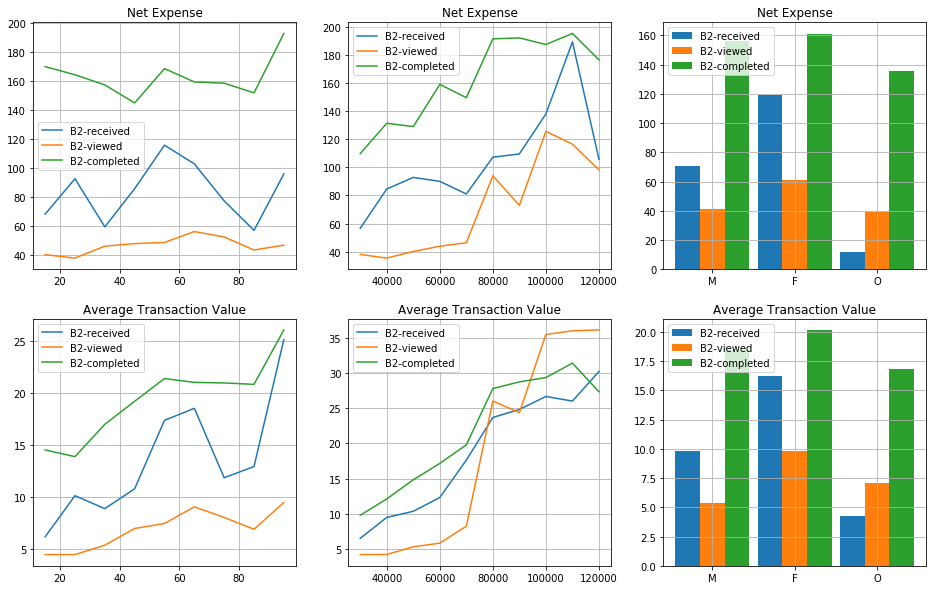

In [104]:
plot_offer_expense_by(customers, 'B2')

This recommendation system doesn't take into account any demographics data. We see that in the selected offer (B2) for people that make more than $90,000 the average transaction value is lower for completed than viewed offers. This offer might not be the best for that population.

### Recommendation system with filters

Knowledge based recommendations for the users using demographics data as filters.

Based on data for customers with:

possitive net_expense
at least 5 transactions completed
only count offers that were both viewed and completed

In [105]:
offers = get_most_popular_offers_filtered(customers, n_top=10, income=95000)
print(offers[0])
print(offers[1])

['B3', 'D3', 'D1', 'D4', 'B1', 'D2', 'B4', 'B2', 'I1', 'I2']
{'B3': 204.325, 'D3': 204.22000000000003, 'D1': 204.21, 'D4': 197.41000000000003, 'B1': 196.62, 'D2': 195.17, 'B4': 187.98, 'B2': 186.17000000000002, 'I1': 185.275, 'I2': 180.41500000000002}


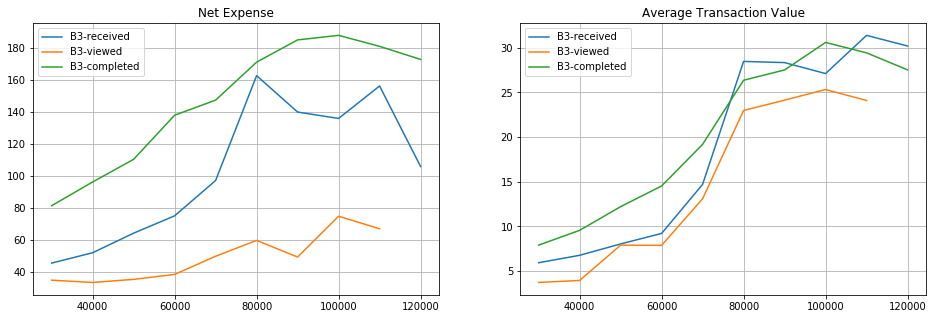

In [106]:
offer = 'B3'
rcv_by, vwd_by, cpd_by = get_offer_stat_by(customers, 'net_expense', offer, 'income_group', aggr='mean')
rcv_avg_by, vwd_avg_by, cpd_avg_by = get_average_expense_by(customers, offer, 'income_group')

plt.figure(figsize=(16,5))

plt.subplot(121)
plt.plot(rcv_by, label='{}-received'.format(offer))
plt.plot(vwd_by, label='{}-viewed'.format(offer))
plt.plot(cpd_by,  label='{}-completed'.format(offer))
plt.legend(loc='best')
plt.title('Net Expense');
plt.grid();

plt.subplot(122)
plt.plot(rcv_avg_by, label='{}-received'.format(offer))
plt.plot(vwd_avg_by, label='{}-viewed'.format(offer))
plt.plot(cpd_avg_by, label='{}-completed'.format(offer))
plt.legend(loc='best')
plt.title('Average Transaction Value');
plt.grid();

Here we see that for this demographic, the completed offers data for the recommended offer (B3) provides both the maximum net expense and average transaction value

Introduce gender to the model

In [107]:

offers = get_most_popular_offers_filtered(customers, n_top=10, gender='M')
print(offers[0])
print(offers[1])

['B2', 'D1', 'B1', 'D4', 'B3', 'B4', 'D3', 'I1', 'D2', 'I2']
{'B2': 138.835, 'D1': 136.89000000000001, 'B1': 136.45, 'D4': 126.485, 'B3': 119.77000000000001, 'B4': 115.60999999999999, 'D3': 110.4, 'I1': 109.575, 'D2': 101.88, 'I2': 71.00500000000001}


The recommendation system provides the same as the systems without filters. Maybe due to the fact that most of the population are men.

In [108]:
offers = get_most_popular_offers_filtered(customers, n_top=10, gender='F')
print(offers[0])
print(offers[1])

['D1', 'D4', 'B1', 'D3', 'B2', 'B4', 'D2', 'I1', 'B3', 'I2']
{'D1': 154.83, 'D4': 154.62, 'B1': 153.745, 'D3': 153.59000000000003, 'B2': 150.37, 'B4': 145.21999999999997, 'D2': 145.03000000000003, 'I1': 142.23, 'B3': 141.60999999999999, 'I2': 132.5}


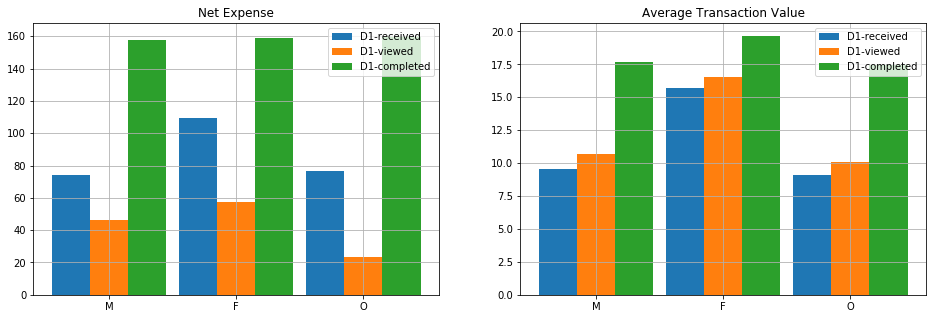

In [109]:
rcv_gender, vwd_gender, cpd_gender = get_offer_stat_by(customers, 'net_expense', 'D1', 'gender', aggr='mean')
rcv_avg_gender, vwd_avg_gender, cpd_avg_gender = get_average_expense_by(customers, 'D1', 'gender')

plt.figure(figsize=(16,5))

plt.subplot(121)
index = np.array([0,1,2])
bar_width = 0.3

plt.bar(index, rcv_gender.reindex(['M', 'F', 'O']), bar_width, label='D1-received')
plt.bar(index + bar_width, vwd_gender.reindex(['M', 'F', 'O']), bar_width, label='D1-viewed')
plt.bar(index + 2*bar_width, cpd_gender.reindex(['M', 'F', 'O']), bar_width, label='D1-completed')
plt.grid();
plt.legend(loc='best');
plt.title('Net Expense');
plt.xticks(index + bar_width, ('M', 'F', 'O'));

plt.subplot(122)

index = np.array([0,1,2])
bar_width = 0.3
plt.bar(index, rcv_avg_gender.reindex(['M', 'F', 'O']), bar_width, label='D1-received')
plt.bar(index + bar_width, vwd_avg_gender.reindex(['M', 'F', 'O']), bar_width, label='D1-viewed')
plt.bar(index + 2*bar_width, cpd_avg_gender.reindex(['M', 'F', 'O']), bar_width, label='D1-completed')
plt.grid();
plt.legend(loc='best');
plt.title('Average Transaction Value');
plt.xticks(index + bar_width, ('M', 'F', 'O'));

We noticed that for women the first recommendation is D1. This shows that women don't care too much of the higher rewards like bogo offers but the coffee itself.

In [110]:
offers = get_most_popular_offers_filtered(customers, n_top=10, gender='O')
print(offers[0])
print(offers[1])

['B3', 'D4', 'B1', 'D3', 'D1', 'D2', 'B2', 'I1', 'B4', 'I2']
{'B3': 162.78000000000003, 'D4': 162.78000000000003, 'B1': 160.93, 'D3': 160.42000000000002, 'D1': 143.25, 'D2': 142.73999999999998, 'B2': 138.84, 'I1': 129.65499999999997, 'B4': 122.44, 'I2': 88.63000000000001}


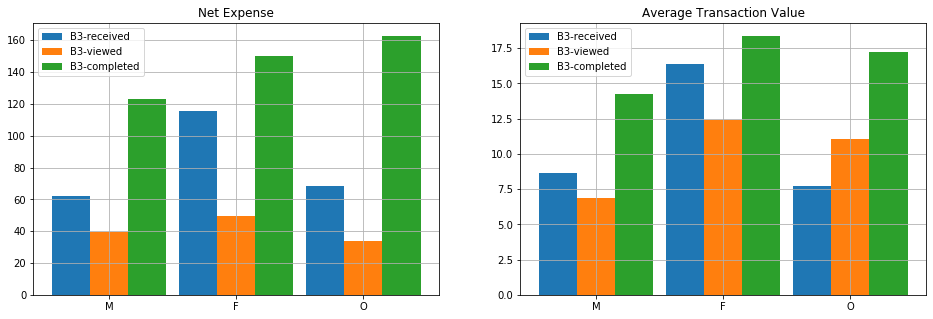

In [111]:
rcv_gender, vwd_gender, cpd_gender = get_offer_stat_by(customers, 'net_expense', 'B3', 'gender', aggr='mean')
rcv_avg_gender, vwd_avg_gender, cpd_avg_gender = get_average_expense_by(customers, 'B3', 'gender')

plt.figure(figsize=(16,5))

plt.subplot(121)
index = np.array([0,1,2])
bar_width = 0.3

plt.bar(index, rcv_gender.reindex(['M', 'F', 'O']), bar_width, label='B3-received')
plt.bar(index + bar_width, vwd_gender.reindex(['M', 'F', 'O']), bar_width, label='B3-viewed')
plt.bar(index + 2*bar_width, cpd_gender.reindex(['M', 'F', 'O']), bar_width, label='B3-completed')
plt.grid();
plt.legend(loc='best');
plt.title('Net Expense');
plt.xticks(index + bar_width, ('M', 'F', 'O'));

plt.subplot(122)

index = np.array([0,1,2])
bar_width = 0.3
plt.bar(index, rcv_avg_gender.reindex(['M', 'F', 'O']), bar_width, label='B3-received')
plt.bar(index + bar_width, vwd_avg_gender.reindex(['M', 'F', 'O']), bar_width, label='B3-viewed')
plt.bar(index + 2*bar_width, cpd_avg_gender.reindex(['M', 'F', 'O']), bar_width, label='B3-completed')
plt.grid();
plt.legend(loc='best');
plt.title('Average Transaction Value');
plt.xticks(index + bar_width, ('M', 'F', 'O'));

Finally, for other gender, the recommended offer is B3. This makes sense since for this offer, the net expense of the other gender is higher than the other genders. The average transaction value is also high, just a $1 less than the one for women.

## 6. Deployment

Before deployment, there are a lot of other modeling can be performed. After submission, I will continue working on it to make it better. Options are:

1. Create ETL pipeline to process the data

2. Create ML pipeline to fit and tune the model.

3. Consider this as a recommendation engine, I could perform Matrix Factorization using FunkSVD.

To be continued in the future!